In [12]:
pip install scikit-learn xgboost joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import dump, load
import pandas as pd
import numpy as np


In [14]:
# Load the dataset you created
df = pd.read_csv("descriptor.csv")
df = df.copy()
df = df[df['Kd'].notnull()]  # Remove NaN
df = df[np.isfinite(df['Kd'])]  # Remove inf/-inf

X = df.drop("Kd", axis=1)
y = df["Kd"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)


In [15]:
df.describe()

,SlogP_VSA5,BCUT2D_CHGHI,SMR_VSA5,MinEStateIndex,Chi4v,Prot_MW,Aromaticity,Instability,Hydropathy,IsoelectricPoint,Kd
count,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000,54864.000000
mean,30.772134,2.276653,34.433113,-1.474322,4.679599,75961.746733,0.084145,46.461172,-0.357673,7.182441,6.053790
std,30.506703,0.146565,44.628280,1.778353,2.851141,54465.646806,0.020082,10.533883,0.296530,1.473318,1.572366
min,0.000000,1.223003,0.000000,-10.494551,0.000000,2448.512800,0.000000,0.307930,-1.610233,4.050028,0.020000
25%,11.984273,2.168639,12.462662,-3.099826,3.246473,44460.111700,0.070175,40.841235,-0.522418,5.974085,5.000000
50%,23.199632,2.248907,25.163779,-0.686605,4.067145,59473.333200,0.082854,46.361345,-0.371148,6.781256,5.443697
75%,39.176306,2.356692,43.671154,-0.240674,5.402720,92901.508400,0.097222,52.685901,-0.239002,8.665856,7.045757
max,498.470808,3.303739,798.900029,2.000000,107.697080,794048.925800,0.186441,90.878018,1.171429,11.721787,15.221849


In [16]:
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

meta_model = LinearRegression()

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

In [ ]:
stacking_model.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_p...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('gbr',
                               GradientBoostingRegressor(random_state=42))],
                  final_estimator=LinearRegression())

In [18]:
y_pred = stacking_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print("Stacked Ensemble MSE:", mse)

Stacked Ensemble MSE: 1.4279824723969676


In [19]:
dump(stacking_model, 'stacked_model.joblib')

['stacked_model.joblib']

In [20]:
test = pd.read_csv("descriptor_test.csv")
x_test = test.drop("Kd", axis=1)
y_test = test["Kd"]

In [21]:
loaded_model = load('stacked_model.joblib')
y_pred = loaded_model.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error , root_mean_squared_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 1.4298
Mean Absolute Error: 0.8909
Root Mean Squared Error: 1.1957


C:\Users\NongNam\AppData\Local\Temp\ipykernel_8140\897430231.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="True Kd", shade=True)
C:\Users\NongNam\AppData\Local\Temp\ipykernel_8140\897430231.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label="Predicted Kd", shade=True)


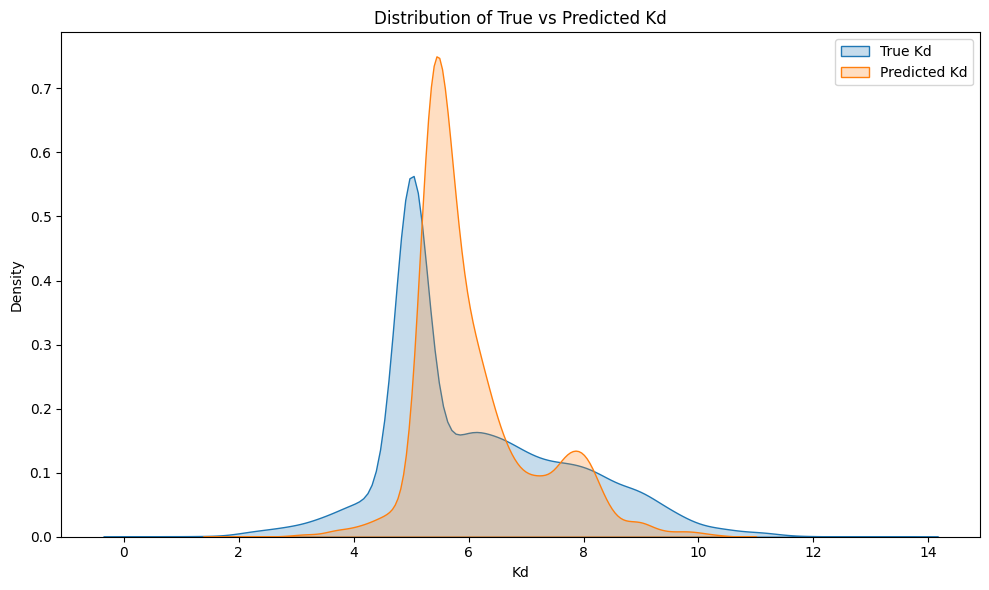

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot real vs predicted distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label="True Kd", shade=True)
sns.kdeplot(y_pred, label="Predicted Kd", shade=True)
plt.title("Distribution of True vs Predicted Kd")
plt.xlabel("Kd")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()